In [1]:
# import packages
import torch
from torch import nn
from torchvision import datasets
from torchvision.transforms import ToTensor
from torch.utils.data import DataLoader

from datetime import datetime
import numpy as np
import time
from fxpmath import Fxp
import os
import json

In [14]:
INPUT_SIZE=784
DEBUG_MODE = True
NETWORK_PARAMETERS = [10,10]

device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {device} device")

training_data = datasets.MNIST(
    root="data",
    train=True,
    download=True,
    transform=ToTensor()
)
test_data = datasets.MNIST(
    root="data",
    train=False,
    download=True,
    transform=ToTensor()
)
batch_size = 1
epochs = 20

# Create data loaders.
train_dataloader = DataLoader(training_data, batch_size=batch_size)
test_dataloader = DataLoader(test_data, batch_size=batch_size)

for X, y in test_dataloader:
    print(f"Shape of X [N, C, H, W]: {X.shape}")
    print(f"Shape of y: {y.shape} {y.dtype}")
    break

Using cpu device
Shape of X [N, C, H, W]: torch.Size([1, 1, 28, 28])
Shape of y: torch.Size([1]) torch.int64


In [15]:
# Define model
class NeuralNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        self.flatten = nn.Flatten()
        network_parameters = [INPUT_SIZE, *NETWORK_PARAMETERS]
        layers = []
        
        for i in range(len(network_parameters)-1):
            layers.append(nn.Linear(network_parameters[i], network_parameters[i+1]))
            layers.append(nn.ReLU())
        layers.pop()
        
        self.linear_relu_stack = nn.Sequential(*layers)
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(28*28, 10),
            nn.ReLU(),
            nn.Linear(10, 10)
            # nn.ReLU(),
            # nn.Linear(LAYER_TWO_SIZE, LAYER_THREE_SIZE)
        )

    def forward(self, x):
        x = self.flatten(x)
        logits = self.linear_relu_stack(x)
        return logits

def train(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    train_loss, error = 0, 0
    
    model.train()
    
    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)

        # Compute prediction error
        pred = model(X)
        loss = loss_fn(pred, y)   
        
        train_loss += loss.item()                                            # cumulative loss
        error += (pred.argmax(1) != y).type(torch.float).sum().item()        # error rate
        
        # Backpropagation
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        if DEBUG_MODE:
            if batch % 6000 == 0:
                loss, current = loss, (batch) * len(X)
                print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")
                
    train_loss /= num_batches
    error /= size
        
    return (train_loss, error)

def test(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    
    model.eval()
    loss, error = 0, 0
    
    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            pred = model(X)
            loss += loss_fn(pred, y).item()
            error += (pred.argmax(1) != y).type(torch.float).sum().item()
            
    loss /= num_batches
    error /= size
    
    if DEBUG_MODE:
        print(f"Test Error: \n Error: {(100*error):>0.1f}%, Avg loss: {loss:>8f} \n")
    
    return (loss , error)

model = NeuralNetwork().to(device)
print(model)
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=1e-3)

NeuralNetwork(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=784, out_features=10, bias=True)
    (1): ReLU()
    (2): Linear(in_features=10, out_features=10, bias=True)
  )
)


In [16]:
# load models based off of original model
model64, model32, model16, model8, model4 = (
    NeuralNetwork().to(device), NeuralNetwork().to(device), 
    NeuralNetwork().to(device), NeuralNetwork().to(device), NeuralNetwork().to(device))

model64.load_state_dict(torch.load('model.pth'))
model32.load_state_dict(torch.load('model.pth'))
model16.load_state_dict(torch.load('model.pth'))
model8.load_state_dict(torch.load('model.pth'))
model4.load_state_dict(torch.load('model.pth'))



<All keys matched successfully>

In [17]:
x64 = Fxp(-7.25, dtype='S10.54', rounding = 'around')
x32 = Fxp(-7.25, dtype='S5.27', rounding = 'around')
x16 = Fxp(-7.25, dtype='S3.13', rounding = 'around')
x8 = Fxp(-7.25, dtype='S2.6', rounding = 'around')
x4 = Fxp(-7.25, dtype='S1.3', rounding = 'around')
print([k.get_val() for k in [x64,x32,x16,x8,x4]])

[-7.25, -7.25, -4.0, -2.0, -1.0]


### Letl's start with the 8-bit model


$$x_q \in [\alpha_q, \beta_q]$$
$$x \in [\alpha, \beta]$$


#### Generate optimal ranges


In [60]:
w1 = model8.linear_relu_stack[0].weight.data
b1 = model8.linear_relu_stack[0].bias.data
w2 = model8.linear_relu_stack[2].weight.data
b2 = model8.linear_relu_stack[2].bias.data

In [90]:
w1_alpha, w1_beta = torch.tensor([ k.min() for k in w1.data]).mean(), torch.tensor([k.max() for k in w1.data]).mean()
b1_alpha, b1_beta = b1.data.min(), b1.data.max()
w2_alpha, w2_beta = torch.tensor([ k.min() for k in w2.data]).mean(), torch.tensor([k.max() for k in w2.data]).mean()
b2_alpha, b2_beta = b2.data.min(), b2.data.max()
print(w1_alpha, w1_beta)
print(b1_alpha, b1_beta)
print(w2_alpha, w2_beta)
print(b2_alpha, b2_beta)

w1_beta = (w1_alpha.abs() + w1_beta)/2
w1_alpha = -w1_beta
b1_beta = (b1_alpha.abs() + b1_beta)/2
b1_alpha = -b1_beta
w2_beta = (w2_alpha.abs() + w2_beta)/2
w2_alpha = -w2_beta
b2_beta = (b2_alpha.abs() + b2_beta)/2
b2_alpha = -b2_beta
print()
print(w1_alpha, w1_beta)
print(b1_alpha, b1_beta)
print(w2_alpha, w2_beta)
print(b2_alpha, b2_beta)

tensor(-0.2646) tensor(0.3173)
tensor(-0.3258) tensor(0.5156)
tensor(-1.1023) tensor(1.1802)
tensor(-0.7727) tensor(1.0735)

tensor(-0.2909) tensor(0.2909)
tensor(-0.4207) tensor(0.4207)
tensor(-1.1413) tensor(1.1413)
tensor(-0.9231) tensor(0.9231)


In [98]:
num = 0.75
exp = 1/torch.log2(torch.tensor(num))
print(num,exp,num**exp)
print(num,2,num**2)
print(num,3,num*3)

0.75 tensor(-2.4094) tensor(2.0000)
0.75 2 0.5625
0.75 3 2.25


NeuralNetwork(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=784, out_features=10, bias=True)
    (1): ReLU()
    (2): Linear(in_features=10, out_features=10, bias=True)
  )
)


tensor([[ 0.0214, -0.0275,  0.0098,  ...,  0.0012, -0.0123,  0.0018],
        [-0.0236, -0.0033, -0.0038,  ...,  0.0212,  0.0238,  0.0165],
        [-0.0104,  0.0087, -0.0064,  ...,  0.0293,  0.0093,  0.0229],
        ...,
        [ 0.0327, -0.0288, -0.0302,  ...,  0.0235, -0.0128, -0.0102],
        [-0.0265, -0.0198,  0.0146,  ...,  0.0205, -0.0245, -0.0037],
        [ 0.0016, -0.0341,  0.0251,  ..., -0.0246, -0.0084,  0.0168]])

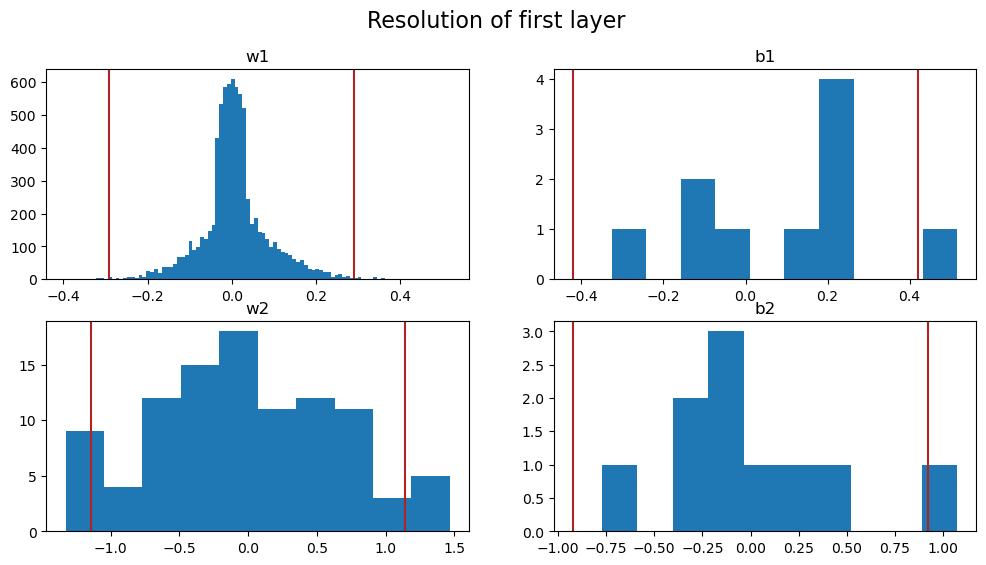

In [91]:
print(model8)
import matplotlib.pyplot as plt
fig,ax = plt.subplots(2,2,figsize=(12,6))
fig.suptitle("Resolution of first layer", fontsize=16)
ax[0,0].set_title('w1')
ax[0,0].hist(w1.flatten(),bins=100)
ax[0,0].axvline(w1_alpha, color='firebrick')
ax[0,0].axvline(w1_beta, color='firebrick')
ax[0,1].set_title('b1')
ax[0,1].hist(b1.flatten(),bins=10)
ax[0,1].axvline(b1_alpha, color='firebrick')
ax[0,1].axvline(b1_beta, color='firebrick')
ax[1,0].set_title('w2')
ax[1,0].hist(w2.flatten(),bins=10)
ax[1,0].axvline(w2_alpha, color='firebrick')
ax[1,0].axvline(w2_beta, color='firebrick')
ax[1,1].set_title('b2')
ax[1,1].hist(b2.flatten(),bins=10)
ax[1,1].axvline(b2_alpha, color='firebrick')
ax[1,1].axvline(b2_beta, color='firebrick')
model8.linear_relu_stack[0].weight.data

In [24]:
alpha, qalpha, beta, qbeta = 0, 0 ,0 ,0

NeuralNetwork(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=784, out_features=10, bias=True)
    (1): ReLU()
    (2): Linear(in_features=10, out_features=10, bias=True)
  )
)

$$\beta=c(\beta_q+d)$$
$$\alpha=c(\alpha_q+d)$$

$$ s=\frac{\beta-\alpha}{\beta_q-\alpha_q} $$
$$z=\frac{\beta\alpha_q-\alpha\beta_q}{\beta-\alpha}$$

In [20]:
scale, zero_point = 0, 0

quant: $$x=s(x_q-z)$$ 
dequant: $$x_q=clip(round(\frac{1}{s}x+z),\alpha_q,\beta_q)$$

In [22]:
quant = lambda x, s, z : np.round((1/s)*x+z)
dequant = lambda x, s, z : s*(x - z) 